In [1]:
import pandas as pd
import numpy as np

import math

from scipy.spatial import distance 
from shapleyx import rshdmr
import spotpy as sp

from scipy.stats import qmc

import matplotlib.pyplot as plt

from itertools import combinations

```
Results here 
```


# Notebook relevant version changes

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%;">
   
* V11 (CV 1-fold: 90.76 / LB: 97.66)
    * Create feature processing per dataset inside the  class FeatureProcessorClass
    * Renaming of the features per dataset
    * Remove latitude/longitude columns for model
    * Add mean_price_per_mwh_gas as feature


* V21 (CV 1-fold: 78.99 / LB: 86.43)
    * Add revealed_target lags from 2 to 7 days ago - inspired from [[Enefit] Baseline + cross-validation ☀️](https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation)
    * Use custom N_days_lags to specify the max number of revealed_target day lags

    
* V23 (CV 1-fold: 72.96 / LB: 83.79)
    * Map latitude & longitude for each county, using code from [mapping locations and county codes
](https://www.kaggle.com/code/fabiendaniel/mapping-locations-and-county-codes)
    * *historical_weather* and *forecast_weather* group by county too, and specify aggegate statistics 
    
    
    
    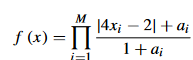
    
    
    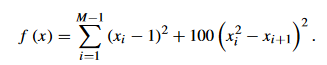

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [8]:
def get_column_labels(n):
    column_labels = []
    for column_index in range(1,n+1):
        column_labels.append('X' + str(column_index)) 
    return column_labels

def ishigami(m):
    n=3
    #a=7
    #b=0.1
    a=2
    b=1
    sampler = qmc.Sobol(d=n, scramble=True, seed=123)
    S = sampler.random_base2(m=m)
    S=S*2*np.pi - np.pi
    Y = np.sin(S[  : ,0]) + a*(np.sin(S[  : ,1])**2) + b*S[  : ,2]**4 * np.sin(S[  : ,0])
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

    
    

In [48]:
# m = 6 -> 64 samples
# m = 7 -> 128 samples
# m = 8 -> 256 samples
# m = 9 -> 512 samples
# m = 10 -> 1024 samples
# m = 11 -> 2048 samples 
# m = 12 -> 4096 samples
# m = 13 -> 8192 samples

m=9 
dataframe = ishigami(m)
print(len(dataframe), 'samples generated')

512 samples generated


In [49]:
dataframe


,X1,X2,X3,Y
0,0.607133,0.982525,-0.234066,1.956347
1,-1.743749,-2.409093,1.878209,-12.349466
2,-0.632661,2.509733,-2.727369,-32.610911
3,1.728958,-1.090534,1.032413,3.682519
4,2.709205,1.710561,3.031147,37.754160
...,...,...,...,...
507,2.715112,-0.379987,0.981532,1.072763
508,1.731493,2.519184,2.906674,72.128671
509,-0.619277,-1.093328,-1.261195,-0.471345
510,-1.766221,1.004507,0.416829,0.413748


 found a dataframe

Transforming data to unit hypercube

['X1', 'X2', 'X3']
X1 : min -3.1390334129985784 max 3.1305404654960824
X2 : min -3.1393275590109404 max 3.1356131924526647
X3 : min -3.1367545494347637 max 3.133173829220537

Building basis functions

 number of terms of order  1 is  30
 number of terms of order  2 is  75

Running regression analysis

running ARD
0 0.57465027855868 inf
1 0.7935444434387675 38.09171822366659
2 0.9395567373627285 18.400014659699117
3 0.9696184888157717 3.199567440432019
4 0.9895185183784196 2.052356652867924
5 0.994999039185589 0.5538573261014419
6 0.9984941222710819 0.35126497090426306
7 0.9990823910658783 0.0589155991683077
8 0.9995729760331409 0.049103554586647793
finished
Iteration: 8, number of features in the model: 10
Iteration: 8, number of features in the model: 10
(8, 0.9995729760331409)
Fit Execution Time : 0.131646
--
 
 Model complete 
 

RS-HDMR model performance statistics

variance of data        : 555.836
sum of coefficients^2   : 

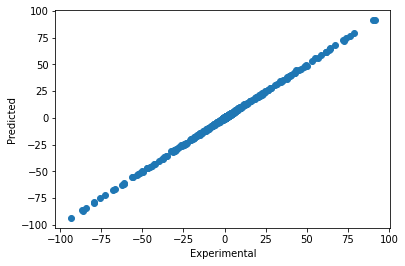


Running bootstrap resampling 1000 samples for 95.0% CI

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

Completed bootstrap resampling


                  Completed all analysis 
                 ------------------------ 

 Feeling and longing are the motive forces behind all human
endeavor and human creations.  Albert Einstein



In [50]:

model = rshdmr(dataframe,
               polys = [10, 5],
               n_iter = 250,
               method = 'ard_cv'
              )
               
sob, shap, total = model.run_all() 

In [51]:
sob

,index,lower,upper
derived_labels,,,
X1,0.383175,0.381627,0.384876
X1_X3,0.615846,0.614146,0.617377
X2,0.000581,0.000517,0.000670


In [52]:
shap

,label,effect,scaled effect,lower,upper
0,X1,0.691098,0.691373,0.690600,0.692208
1,X2,0.000581,0.000581,0.000518,0.000670
2,X3,0.307923,0.308046,0.307201,0.308824


In [53]:
total

,label,total
0,X1,0.999022
1,X2,0.000581
2,X3,0.615846


In [17]:
model.get_pawnx(1000, 1000, 1000, alpha=0.05)

For the Kolmogorov–Smirnov test with alpha = 0.050 the critical value is 0.061
3
1 0.4635 0.043859772901828846
2 0.084 0.019048440881080004
3 0.309 0.013771052392609652


,minimum,mean,median,maximum,stdev,null hyp
X1,0.355,0.456139,0.4635,0.523,0.04386,reject
X2,0.023,0.07967,0.084,0.12,0.019048,reject
X3,0.264,0.302454,0.309,0.321,0.013771,reject


In [54]:
model.get_pawn()

,minimum,mean,median,maximum,CV,stdev
X1,0.402191,0.466779,0.467620,0.542892,0.101438,0.047349
X2,0.069049,0.112764,0.119600,0.142578,0.218960,0.024691
X3,0.158203,0.254487,0.250977,0.324027,0.231629,0.058947


In [11]:


def xsampler(n, ranges):
    num_features = len(ranges)
    lower = []
    upper = []
    sampler = qmc.LatinHypercube(d=num_features)
    sample = sampler.random(n=n)
    
    for the_range in ranges:
        lower.append(ranges[the_range][0])
        upper.append(ranges[the_range][1])

    sample_scaled = qmc.scale(sample, lower, upper)

    return sample_scaled 

In [28]:
from scipy.stats import qmc

def xsamplery(n, ranges):
    num_features = len(ranges)
    lower = []
    upper = []
    sampler = qmc.LatinHypercube(d=num_features)
    sample = sampler.random(n=n)
    
    for the_range in ranges:
        lower.append(ranges[the_range][0])
        upper.append(ranges[the_range][1])

    sample_scaled = qmc.scale(sample, lower, upper)

    return sample_scaled 

In [37]:
from scipy.stats import ks_2samp 

a=2
b=1

def calc_function(S) : 
    Y = np.sin(S[  : ,0]) + a*(np.sin(S[  : ,1])**2) + b*S[  : ,2]**4 * np.sin(S[  : ,0])
    return Y

def get_pawnxy(Nu : int, Nc : int, M : int, alpha=0.05):
    """
    Calculate PAWN indices for the RS-HDMR surrogate function

    Args:
        Nu (int): Number of unconditioned samples
        Nc (int): Number of conditioned samples
        M (int): Number of KS samples
        alpha (float, optional): p value for KS test. Defaults to 0.05.

    Returns:
        _type_: Dataframe
    """
    
    calpha = np.sqrt(-np.log(alpha/2)/2)
    Dnm = np.sqrt((Nu+Nc)/(Nu*Nc))
    critical_value = Dnm*calpha
    print(f'For the Kolmogorov–Smirnov test with alpha = {alpha:.3f} the critical value is {critical_value:.3f}')
    
    results = {} 
    resultsp = {}
    labels = model.X.columns
    num_features = len(model.ranges)
    #generate reference set
    x_ref = xsamplery(Nu, model.ranges)
    y_ref = calc_function(x_ref)
    print(num_features)
    for j in range(num_features):
        accept = 'accept'
        all_stats = []
        all_p = []
        for i in range(M):
            Xi = np.random.rand()
            Xn = xsamplery(Nc, model.ranges)
            Xn[:,j] = Xi
            Yn = calc_function(Xn)
            ks = ks_2samp(y_ref, Yn)
            all_stats.append(ks.statistic)
            all_p.append(ks.pvalue)

        min = np.min(all_stats)
        mean = np.mean(all_stats)
        median = np.median(all_stats)
        max = np.max(all_stats)
        std = np.std(all_stats)

        minp = np.min(all_p)
        meanp = np.mean(all_p)
        medianp = np.median(all_p)
        maxp = np.max(all_p)
        stdp = np.std(all_p)
        if minp < alpha :
            accept = 'reject'

        results[labels[j]] = [min, mean, median, max, std, accept] 
        resultsp[labels[j]] = [minp, meanp, medianp, maxp, stdp, accept] 
        print(j+1, np.median(all_stats),np.std(all_stats))

    headings = ['minimum', 'mean', 'median', 'maximum', 'stdev', 'null hyp']
    results = pd.DataFrame(results).T
    resultsp = pd.DataFrame(resultsp).T

    results.columns = headings
    resultsp.columns = headings
    return results  


In [55]:
get_pawnxy(100, 50, 15, alpha=0.05)

For the Kolmogorov–Smirnov test with alpha = 0.050 the critical value is 0.235
3
1 0.44 0.03480740661921763
2 0.17 0.03930507459462313
3 0.33 0.022803508501982758


,minimum,mean,median,maximum,stdev,null hyp
X1,0.39,0.444667,0.44,0.5,0.034807,reject
X2,0.11,0.171333,0.17,0.25,0.039305,reject
X3,0.29,0.33,0.33,0.37,0.022804,reject


In [56]:
model.get_pawnx(100, 50, 15, alpha=0.05)

For the Kolmogorov–Smirnov test with alpha = 0.050 the critical value is 0.235
3
1 0.5 0.03525147751040611
2 0.1 0.0303021818063027
3 0.34 0.017461067804945052


,minimum,mean,median,maximum,stdev,null hyp
X1,0.41,0.492,0.5,0.55,0.035251,reject
X2,0.07,0.108667,0.1,0.16,0.030302,accept
X3,0.31,0.335333,0.34,0.36,0.017461,reject


In [61]:
model.get_pawn(10)

,minimum,mean,median,maximum,CV,stdev
X1,0.402191,0.466779,0.467620,0.542892,0.101438,0.047349
X2,0.069049,0.112764,0.119600,0.142578,0.218960,0.024691
X3,0.158203,0.254487,0.250977,0.324027,0.231629,0.058947
